In [1]:
import numpy as np
import xarray as xr

import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
from scipy.signal import welch, csd
from scipy.stats import chi2

Open and wrangle the raw SAIL EC data

In [2]:
DATE = '20230418'

In [3]:
fast_data_file_path = f"/Users/elischwat/Development/data/sublimationofsnow/sail_fast_ecor_data/gucecorM1.00.{DATE}.000000.raw/**_sonic.raw"
fast_data_files = glob.glob(fast_data_file_path)

In [4]:
def read_and_process_raw_sonic(file):
    high_rate_df = pd.read_csv(file, skiprows=1, header=None).rename(columns = 
    dict(zip(range(0,10), ['Timestamp',
        'u',
        'v',
        'w',
        'windspeed units (M = m/s)',
        'Speed of Sound',
        'Status (00 means okay)',
        'CO2 analog voltage output',
        'H20 analog voltage output',
        'Checksum',]))
    )
    high_rate_df['Timestamp'] = pd.to_datetime(
        f'{DATE} ' + high_rate_df['Timestamp'].str[:-3],
        format="%Y%m%d %H:%M:%S.%f"
    )
    return high_rate_df

In [5]:
df = pd.concat([read_and_process_raw_sonic(f) for f in sorted(fast_data_files)]).reset_index(drop=True)
# df = df.sort_values('Timestamp')
df = df.rename(columns = {'Timestamp': 'time'})

In [9]:
import scipy.stats
scipy.stats.skew(df['w'].dropna())

-0.7738947370153748

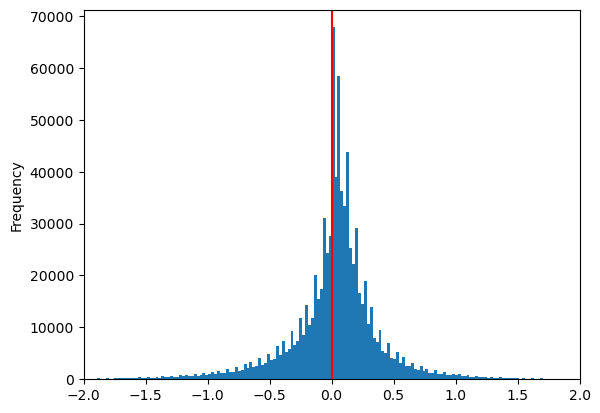

In [6]:
df['w'].plot.hist(bins=500)
plt.xlim(-2,2)
plt.axvline(0, color='red')

In [15]:
df['w'] = df['w'].ffill()

In [16]:
df_day = df[
    (df['time'] >= f'{DATE} 1500')
    &
    (df['time'] <  f'{DATE} 2300')
]

df_early_morn = df[
    (df['time'] < f'{DATE} 1500')
]

df_night = df[
    (df['time'] >  f'{DATE} 2300')
]




# df_day = df[
#     (df['time'] >= '2023-04-18 1500')
#     &
#     (df['time'] <  '2023-04-18 2300')
# ]

# df_early_morn = df[
#     (df['time'] < '2023-04-18 1500')
# ]

# df_night = df[
#     (df['time'] >  '2023-04-18 2300')
# ]

Calculate MRD

In [31]:
def newmrd(data_a, data_b, M, Mx):
    D = np.zeros(M - Mx)
    Dstd = np.copy(D)
    data_a2 = np.copy(data_a)
    data_b2 = np.copy(data_b)
    for ims in range(M - Mx + 1):
        ms = M - ims
        l = 2 ** ms
        nw = round((2 ** M) / l)
        wmeans_a = np.zeros(nw)
        wmeans_b = np.copy(wmeans_a)
        for i in range(nw):
            k = round(i * l)
            wmeans_a[i] = np.mean(data_a2[k:(i+1)*l])
            wmeans_b[i] = np.mean(data_b2[k:(i+1)*l])
            data_a2[k:(i+1)*l] -= wmeans_a[i]
            data_b2[k:(i+1)*l] -= wmeans_b[i]
        if nw > 1:
            D[ms] = np.mean(wmeans_a * wmeans_b)
            Dstd[ms] = np.std(wmeans_a * wmeans_b, ddof=0)
    return D, Dstd

def calculate_mrd_for_df(df, VAR1, VAR2):
    M = int(np.floor(np.log2(len(df))))
    print(f"Got data of length {len(df)}. using M = {M}")
    timestep = (
        df['time'].iloc[1] - df['time'].iloc[0]
    ).total_seconds() * 1000
    print(f"Timestep of fast data is: {timestep}")
    mrd_x = np.array([
        dt.timedelta(milliseconds=2**i * timestep).total_seconds() 
        for i in range(1, M+1)
    ])
    result = newmrd(
        df[VAR1], 
        df[VAR2],
        M, 
        0
    )
    return pd.DataFrame({
        'tau':      mrd_x,
        'Co':       result[0],
        'std':      result[1]
    })

In [18]:
mrd_day_df = calculate_mrd_for_df(df_day, 'w', 'w').assign("variable = 'w'w'")
mrd_night_df = calculate_mrd_for_df(df_night, 'w', 'w').assign("variable = 'w'w'")

mrd_df = pd.concat([
    mrd_day_df.assign(type = 'day'),
    mrd_night_df.assign(type = 'night')
])

mrd_df.to_parquet(f"mrds_{DATE}.parquet")

Got data of length 288006. using M = 18
Timestep of fast data is: 100.0
Got data of length 36000. using M = 15
Timestep of fast data is: 90.0


In [19]:
mrd_df = pd.concat([
    pd.read_parquet("mrds_20230415.parquet").assign(date = '20230415'),
    pd.read_parquet("mrds_20230418.parquet").assign(date = '20230418')
])

In [21]:
base_chart = alt.Chart(mrd_df).transform_calculate(
    xlow = 'datum.Co - datum.std',
    xhigh = 'datum.Co + datum.std'
).encode(
    alt.X('tau:Q').scale(type='log').title('tau (s)'),
    alt.Color('date:N')
    # alt.Color('type:N')
)
(base_chart.mark_line().encode(
    alt.Y('Co:Q')
) + base_chart.mark_errorband(opacity=0.25).encode(
    alt.Y('xlow:Q'), alt.Y2('xhigh:Q')
)).facet('type:N')

alt.FacetChart(...)

In [30]:
base_chart.mark_line().encode(
    alt.Y('Co:Q').title("Co(w'w')")
).properties(width=150, height=100).facet('type:N')

alt.FacetChart(...)